In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from brian2 import *

from utils.funcs import basic_namespace, compIFcurve_by_equation, plotIFcurve
from utils.modified_base_eq import base_eq, Lnav_eq, Lnav_eq_new

prefs.codegen.target = "numpy"

# Как оно исходно выглядит и работает

## Воротные переменные

In [1329]:
vv = linspace(-80, 20, 100)
# base
VT = basic_namespace["VT"] / mV
a_shift = + 3
b_shift = + 3
a_m = 0.32 * 4 * 0.8 / exprel((13 - vv + VT + a_shift)/4)
b_m = 0.28 * 5 / exprel((vv - VT - 40 + b_shift)/5)
m_inf = a_m / (a_m + b_m)
tau_m = 1 / (a_m + b_m)

a_shift = 10
b_shift = 10  # +5 у обоих рейтов работает неплохо (но мало по амплитуде)
a_h = 0.128*0.2 * exp((17 - vv + VT + a_shift)/18)
b_h = 4*0.2 / (1 + exp((40 - vv + VT + b_shift)/5))
h_inf = a_h / (a_h + b_h)
tau_h = 1 / (a_h + b_h)

# Literature
la_m = 2.85 - 2.84 / (1 + exp((vv - 1.16)/13.95))
lb_m = 7.62 / (1 + exp((vv + 46.5)/8.83))  
lm_inf = la_m / (la_m + lb_m)
ltau_m = 1 / (la_m + lb_m)

la_m_new = 2.85*1. - 2.85*1. / (1 + exp((vv - 1.16 + 10)/13.94/0.4))  #
lb_m_new = 7.62*1. / (1 + exp((vv + 46.5 + 16)/8.83/1))
lm_inf_new = la_m_new / (la_m_new + lb_m_new)
ltau_m_new = 1 / (la_m_new + lb_m_new)

lh_tau = 1.218 + 42. * exp(-((vv + 38.1)**2) / (2*15.2**2))
lh_tau_new = 1.218 + 42. *0.6 * exp(-((vv + 38.1 + 40)**2) / (2*15.2**2))

lh_inf = 1 / (1 + exp((vv + 32.2)/4))
lh_inf_new = 1*1. / (1 + exp((vv + 32.2 + 15)/4/0.8))


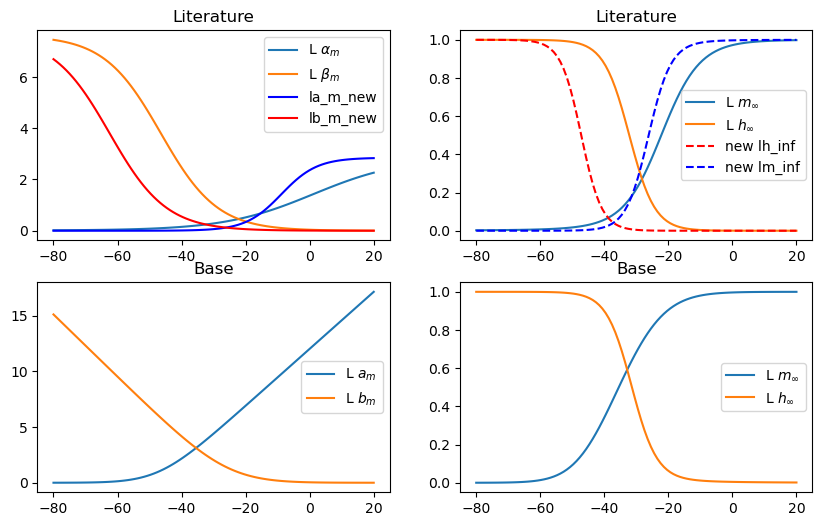

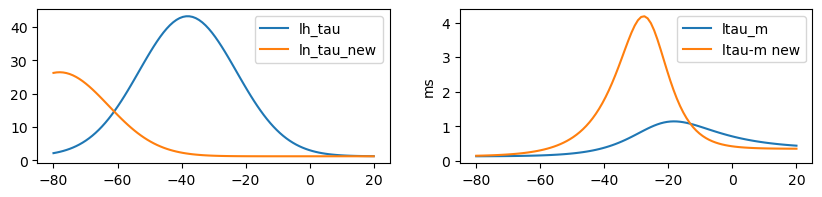

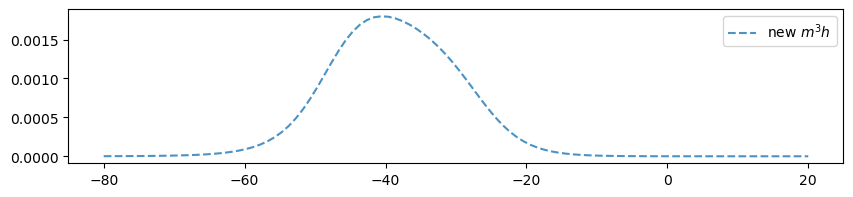

In [1330]:
figure(figsize=(10, 6))
subplot(2, 2, 1)
title("Literature")
plot(vv, la_m, label="L $\\alpha_m$")
plot(vv, lb_m, label="L $\\beta_m$")
plot(vv, la_m_new, 'b', label="la_m_new")
plot(vv, lb_m_new, 'r', label="lb_m_new")
legend()
subplot(2, 2, 2)
title("Literature")
plot(vv, lm_inf, label="L $m_\\infty$")
plot(vv, lh_inf, label="L $h_\\infty$")
plot(vv, lh_inf_new, 'r--', label="new lh_inf")
plot(vv, lm_inf_new, 'b--', label="new lm_inf")
legend()
subplot(2, 2, 3)
title("Base")
plot(vv, a_m, label="L $a_m$")
plot(vv, b_m, label="L $b_m$")
legend()
subplot(2, 2, 4)
title("Base")
plot(vv, m_inf, label="L $m_\\infty$")
plot(vv, h_inf, label="L $h_\\infty$")
legend()
figure(figsize=(10,2))
subplot(1, 2, 1)
plot(vv, lh_tau, label='lh_tau')
plot(vv, lh_tau_new, label='ln_tau_new')
legend()
subplot(1, 2, 2)
plot(vv, ltau_m, label="ltau_m")
plot(vv, ltau_m_new, label="ltau-m new")
ylabel("ms")
legend()
figure(figsize=(10, 2))
plot(vv, lm_inf_new * lh_inf_new, "--", alpha=0.8, label="new $m^3h$")
#plot(vv, m_inf**3*h_inf, "--", alpha=0.8, label="$m^3h$")
legend()

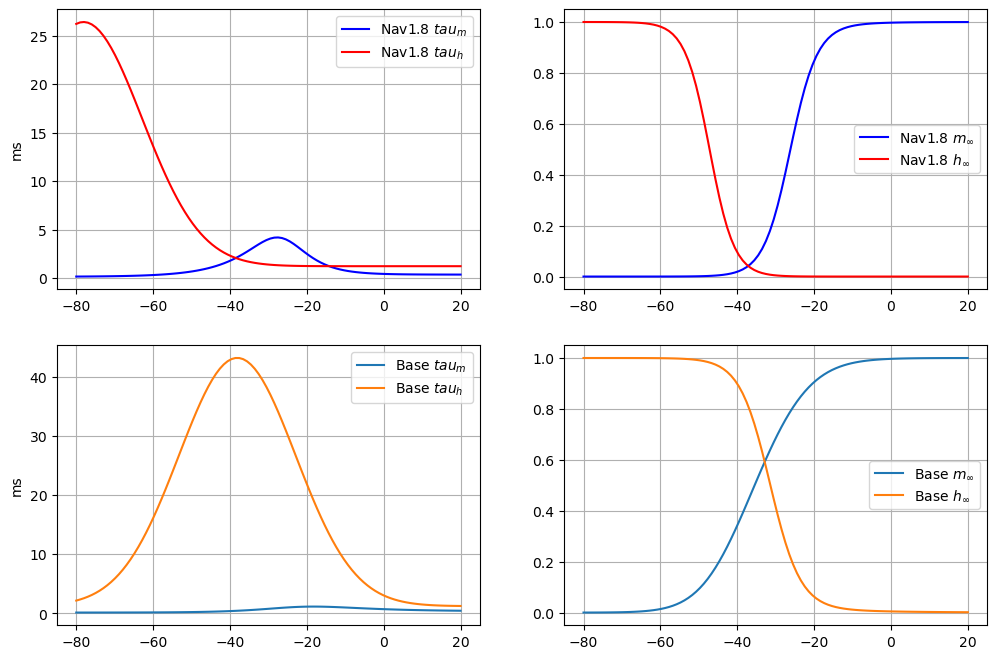

In [1406]:
# REPORT PLOTS
figure(figsize=(12, 8))
subplot(2, 2, 1)
plot(vv, ltau_m_new, "b", label="Nav1.8 $tau_m$")
plot(vv, lh_tau_new, "r", label="Nav1.8 $tau_h$")
ylabel("ms")
legend()
grid(True, which="both")
subplot(2, 2, 2)
plot(vv, lm_inf_new, "b", label="Nav1.8 $m_\\infty$")
plot(vv, lh_inf_new, "r", label="Nav1.8 $h_\\infty$")
legend()
grid(True, which="both")
subplot(2, 2, 3)
plot(vv, ltau_m, "tab:blue", label="Base $tau_m$")
plot(vv, lh_tau, "tab:orange", label="Base $tau_h$")
ylabel("ms")
legend()
grid(True, which="both")
subplot(2, 2, 4)
plot(vv, m_inf, "tab:blue", label="Base $m_\\infty$")
plot(vv, h_inf, "tab:orange", label="Base $h_\\infty$")
legend()
grid(True, which="both")
#savefig("images/3IF_curve_gate_vars.jpg", dpi=150)

Если нав18 (хороший) больше похож на основной нав, можно ли вызвать нужный эффекто просто увеличив проводимость нав?

А нет, кажется, я лагнул, они таки отличаются (уж точно временными константами)

## Динамика воротных переменных

In [1380]:
if_namespace = basic_namespace.copy()
if_namespace["gNa"] = 25*nS
if_namespace["gNa18"] = 15*nS
if_namespace["gL"] = 2.5 *nS

In [1377]:
baseifmon, baseifgroup = compIFcurve_by_equation(base_eq, if_namespace, max_cur=200, N=25)
#lnavifmon, lnavifgroup = compIFcurve_by_equation(Lnav_eq, if_namespace, max_cur=100, N=50)

In [1381]:
from utils.modified_base_eq import Lnav_eq_new
lnvaifmon_new, lnvaifgroup_new = compIFcurve_by_equation(Lnav_eq_new, if_namespace, max_cur=200, N=25)

На текущих параметрах разваливается. Хотя параметры выглядят нормальными. Почему разваливается?

Может быть, не хватает скорости инактивации?

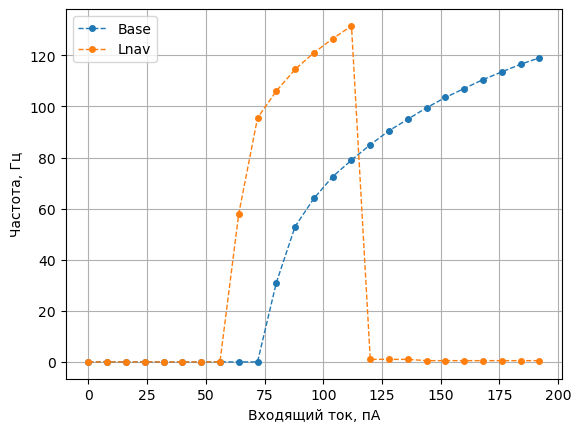

In [1382]:
plotIFcurve(baseifmon, baseifgroup)
#plotIFcurve(lnavifmon, lnavifgroup)
plotIFcurve(lnvaifmon_new, lnvaifgroup_new)
legend(["Base", "Lnav", "Lnav_new"])

In [1385]:
# REPORT PLOTS
if_namespace5 = if_namespace.copy()
if_namespace5["gNa18"] = 5*nS
ifmon5, ifgroup5 = compIFcurve_by_equation(Lnav_eq_new, if_namespace5, max_cur=150, N=25)
if_namespace10 = if_namespace.copy()
if_namespace10["gNa18"] = 10*nS
ifmon10, ifgroup10 = compIFcurve_by_equation(Lnav_eq_new, if_namespace10, max_cur=150, N=25)
if_namespace15 = if_namespace.copy()
if_namespace15["gNa18"] = 15*nS
ifmon15, ifgroup15 = compIFcurve_by_equation(Lnav_eq_new, if_namespace15, max_cur=150, N=25)

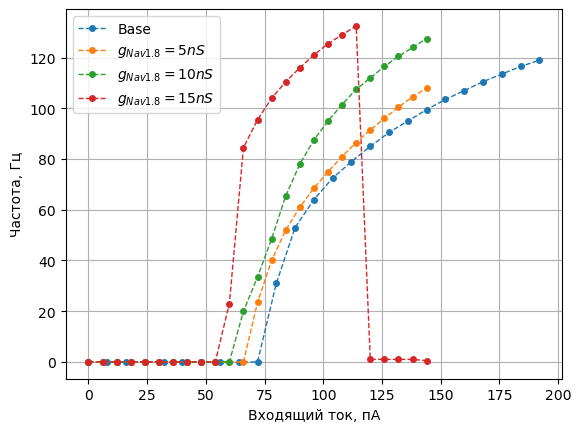

In [1387]:
# REPORT PLOTS
plotIFcurve(baseifmon, baseifgroup)
plotIFcurve(ifmon5, ifgroup5)
plotIFcurve(ifmon10, ifgroup10)
plotIFcurve(ifmon15, ifgroup15)
legend(["Base", "$g_{Nav1.8}=5nS$", "$g_{Nav1.8}=10nS$", "$g_{Nav1.8}=15nS$"])
savefig("images/3IFcurve.jpg", dpi=150)

In [50]:
sample_currents = [70, 100, 150] * pA

In [1237]:
start_scope()
base_neuron = NeuronGroup(1, model=base_eq, method="exponential_euler",
                          namespace=if_namespace)
base_mon = StateMonitor(base_neuron, ["v", "m", "h"], True)
base_neuron.v = basic_namespace["El"]

run(50*ms)
for cur in sample_currents:
    base_neuron.I = cur
    run(100*ms)
    base_neuron.I = 0 * pA
    run(10*ms)

In [657]:
start_scope()
lnav_neuron = NeuronGroup(1, model=Lnav_eq, method="exponential_euler",
                        namespace=if_namespace)
lnav_mon = StateMonitor(lnav_neuron, ["v", "m", "h", "mNa18", "hNa18", "INa18"], True)
lnav_neuron.v = basic_namespace["El"]

run(50*ms)
for cur in sample_currents:
    lnav_neuron.I = cur
    run(100*ms)
    lnav_neuron.I = 0 * pA
    run(10*ms)

In [1367]:
from utils.modified_base_eq import Lnav_eq_new
start_scope()
if_namespace["gNa18"] = 10*nS  # 5
if_namespace["gNa"] = 25*nS
if_namespace["gL"] = 2.5*nS
lnav_neuron_new = NeuronGroup(1, model=Lnav_eq_new, method="exponential_euler",
                        namespace=if_namespace)
lnav_mon_new = StateMonitor(lnav_neuron_new, ["v", "m", "h", "mNa18", "hNa18", "INa18"], True)
lnav_neuron_new.v = basic_namespace["El"]

run(50*ms)
for cur in sample_currents:
    lnav_neuron_new.I = cur
    run(100*ms)
    lnav_neuron_new.I = 0 * pA
    run(10*ms)

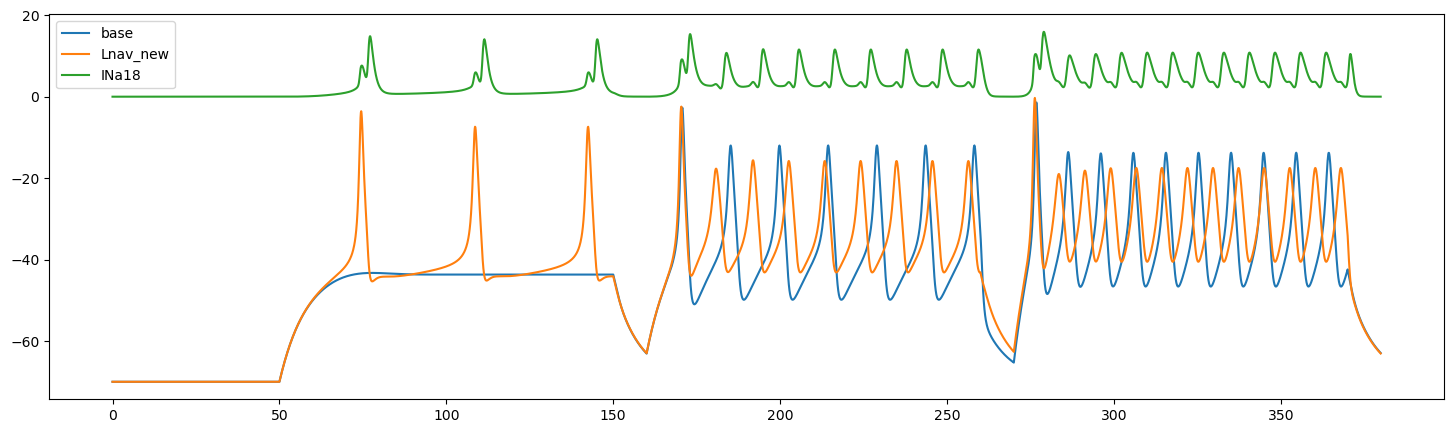

In [1409]:
figure(figsize=(18, 5))
plot(base_mon.t/ms, base_mon.v[0]/mV, label="base")
#plot(lnav_mon.t/ms, lnav_mon.v[0]/mV, label="Lnav")
plot(lnav_mon_new.t/ms, lnav_mon_new.v[0]/mV, label="Lnav_new")
plot(lnav_mon_new.t/ms, lnav_mon_new.INa18[0]/pA / 10, label="INa18")
legend()
#savefig("images/3IF_spikes.jpg", dpi=150)

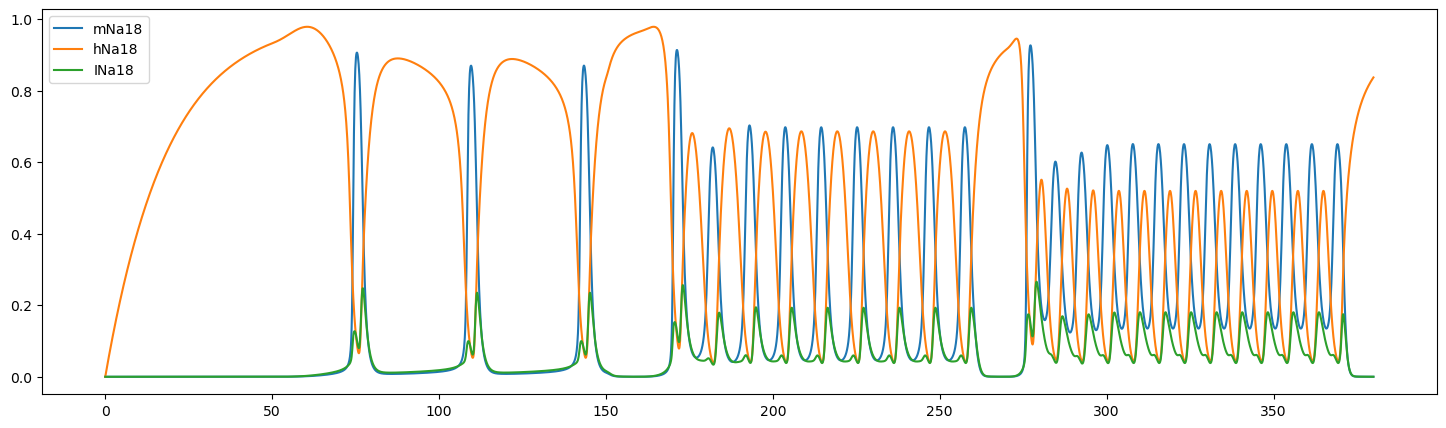

In [1410]:
figure(figsize=(18, 5))
#plot(lnav_mon_new.t/ms, lnav_mon_new.m[0], label="m")
#plot(lnav_mon_new.t/ms, lnav_mon_new.h[0], label="h")
plot(lnav_mon_new.t/ms, lnav_mon_new.mNa18[0], label="mNa18")
plot(lnav_mon_new.t/ms, lnav_mon_new.hNa18[0], label="hNa18")
plot(lnav_mon_new.t/ms, lnav_mon_new.INa18[0]/pA/600, label="INa18")
legend()
#savefig("images/3IF_gate_vars_dynamics.jpg", dpi=150)

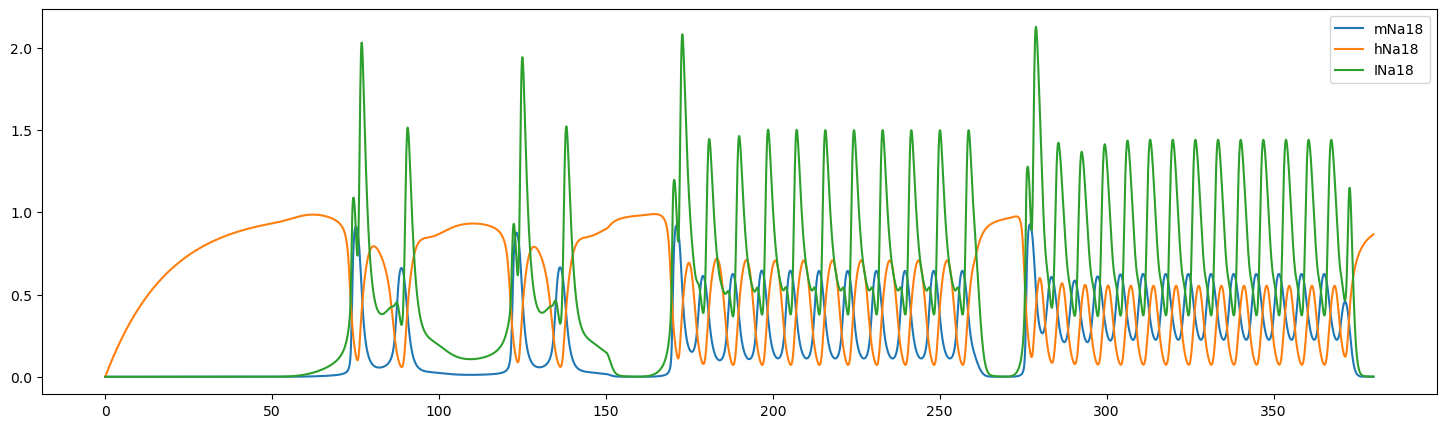

In [1366]:
figure(figsize=(18, 5))
plot((lnav_mon_new.t/ms), (lnav_mon_new.mNa18[0]), label="mNa18")
plot((lnav_mon_new.t/ms), (lnav_mon_new.hNa18[0]), label="hNa18")
plot(lnav_mon_new.t/ms, lnav_mon_new.INa18[0]/pA/100, label="INa18")
legend()

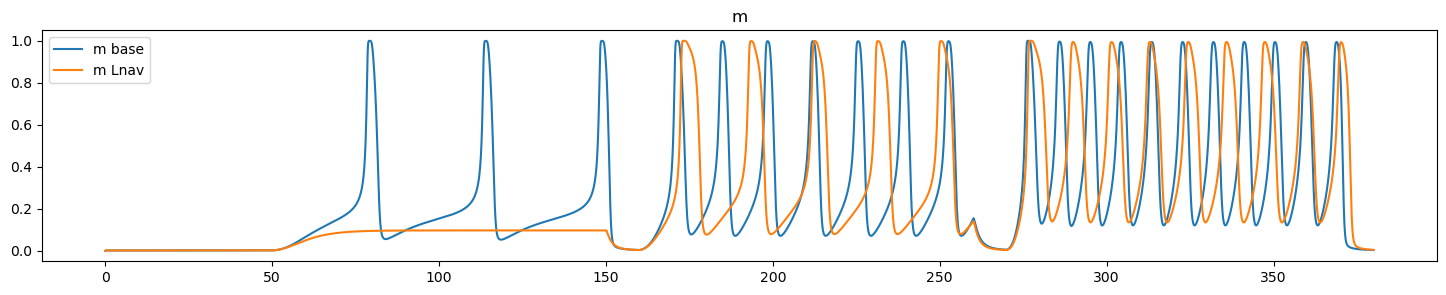

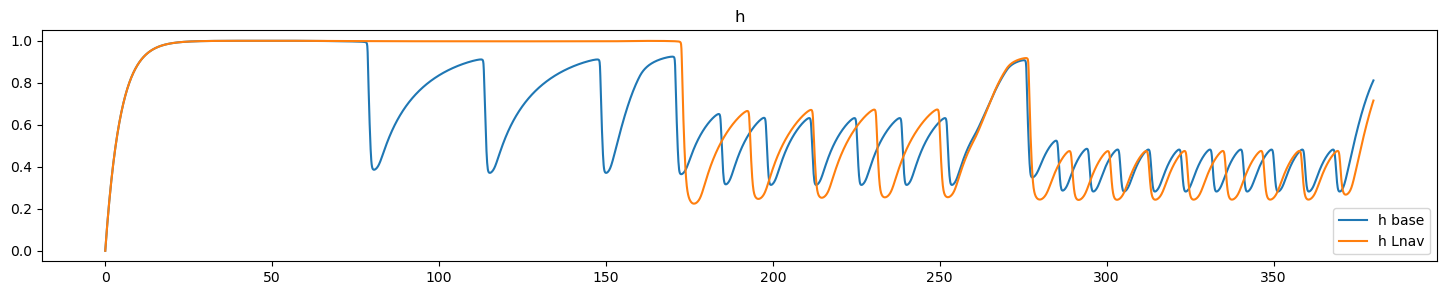

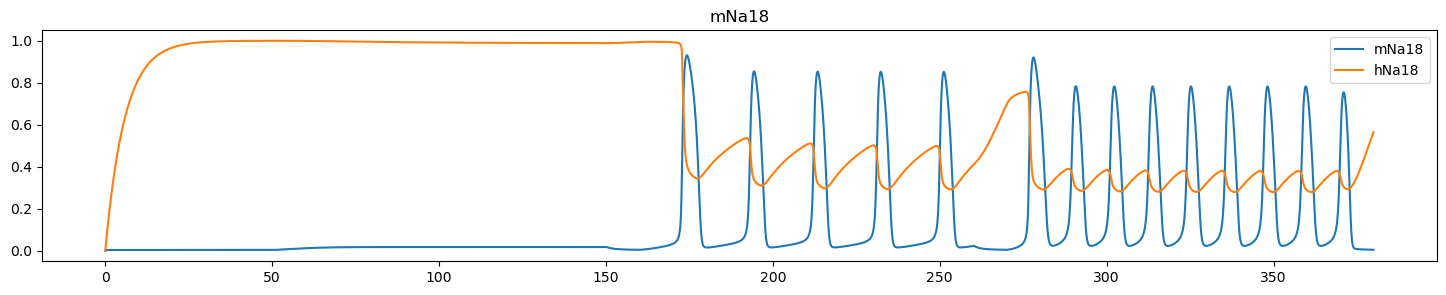

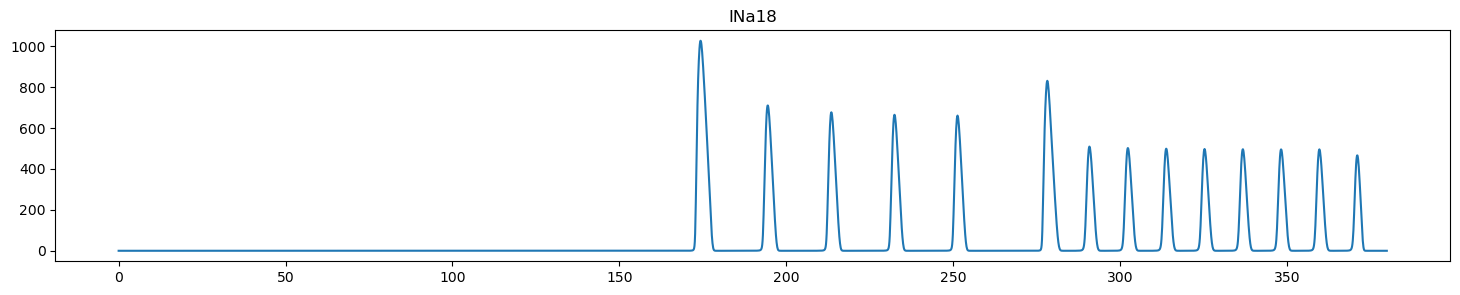

In [821]:
figure(figsize=(18, 3))
title("m")
plot(base_mon.t/ms, base_mon.m[0], label="m base")
plot(lnav_mon.t/ms, lnav_mon.m[0], label="m Lnav")
legend()
figure(figsize=(18, 3))
title("h")
plot(base_mon.t/ms, base_mon.h[0], label="h base")
plot(lnav_mon.t/ms, lnav_mon.h[0], label="h Lnav")
legend()
figure(figsize=(18, 3))
title("mNa18")
plot(lnav_mon.t/ms, lnav_mon.mNa18[0], label="mNa18")
plot(lnav_mon.t/ms, lnav_mon.hNa18[0], label="hNa18")
legend()
figure(figsize=(18, 3))
title("INa18")
plot(lnav_mon.t/ms, lnav_mon.INa18[0]/pA, label="INa18")


Text(0.5, 1.0, 'hNa18 vs h')

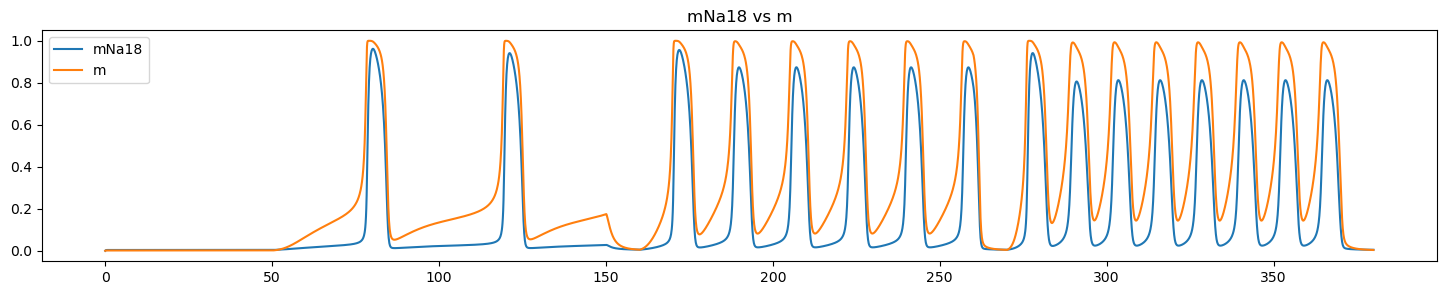

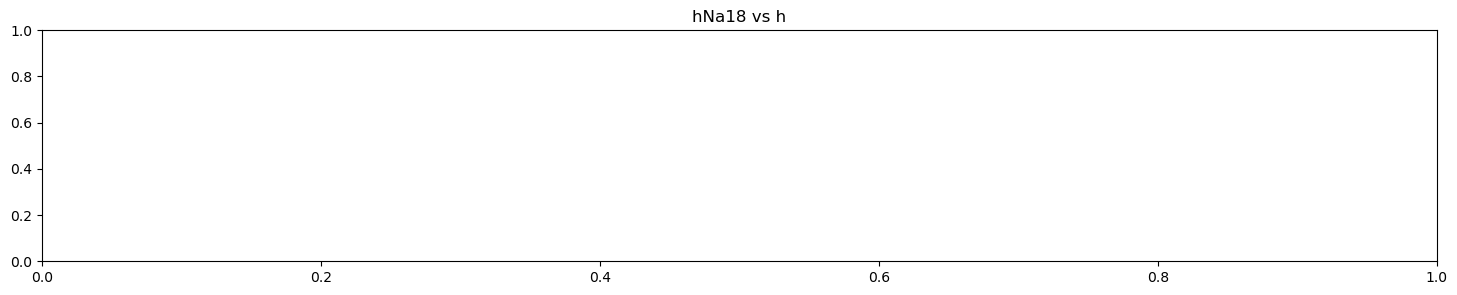

In [55]:
figure(figsize=(18, 3))
title("mNa18 vs m")
plot(lnav_mon.t/ms, lnav_mon.mNa18[0], label="mNa18")
plot(lnav_mon.t/ms, lnav_mon.m[0], label="m")
legend()
figure(figsize=(18, 3))
title("hNa18 vs h")


# Пробуем подвигать